In [ ]:
"""
Text Mining and Diffusion Analysis Pipeline
This module performs exploratory data analysis on text data using diffusion geometry
and manifold learning techniques. It processes text documents through TF-IDF vectorization,
applies SVD dimensionality reduction, and constructs diffusion maps to analyze the
geometric structure of the text corpus.
Key Features:
- TF-IDF vectorization with preprocessing
- SVD-based dimensionality reduction and variance analysis
- Non-negative matrix factorization for probabilistic interpretation
- Entropy-based similarity kernel construction
- Markov chain diffusion process modeling
- Von Neumann entropy computation across diffusion times
- Diffusion distance calculation for manifold geodesics
- K-nearest neighbors graph construction for connectivity
- Geodesic path finding using Dijkstra's algorithm
- Network visualization with spring layout and minimum spanning tree
The pipeline is designed to discover semantic relationships in text data by modeling
the corpus as a diffusion process on a manifold, enabling the computation of
meaningful distances and paths between documents based on their content similarity.
Dependencies:
- Scientific computing: numpy, scipy, pandas
- Machine learning: scikit-learn, sentence-transformers
- Text processing: gensim, datasets
- Visualization: matplotlib, networkx
- Optimization: numba (for fast distance computations)
- Dimensionality reduction: umap
- Clustering: hdbscan, bertopic
Input: CSV file containing text documents with columns ['text', 'url', 'topic']
Output: Diffusion maps, entropy measures, geodesic paths, and network visualizations
"""
import gc
import os
import pickle
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from bertopic import BERTopic
from datasets import load_dataset
from gensim.parsing.preprocessing import preprocess_string
from hdbscan import HDBSCAN
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange
from scipy.linalg import fractional_matrix_power
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from umap import UMAP

In [ ]:
"""
Text Mining and Diffusion Analysis Pipeline
This module performs exploratory data analysis on text data using diffusion geometry
and manifold learning techniques. It processes text documents through TF-IDF vectorization,
applies SVD dimensionality reduction, and constructs diffusion maps to analyze the
geometric structure of the text corpus.
Key Features:
- TF-IDF vectorization with preprocessing
- SVD-based dimensionality reduction and variance analysis
- Non-negative matrix factorization for probabilistic interpretation
- Entropy-based similarity kernel construction
- Markov chain diffusion process modeling
- Von Neumann entropy computation across diffusion times
- Diffusion distance calculation for manifold geodesics
- K-nearest neighbors graph construction for connectivity
- Geodesic path finding using Dijkstra's algorithm
- Network visualization with spring layout and minimum spanning tree
The pipeline is designed to discover semantic relationships in text data by modeling
the corpus as a diffusion process on a manifold, enabling the computation of
meaningful distances and paths between documents based on their content similarity.
Dependencies:
- Scientific computing: numpy, scipy, pandas
- Machine learning: scikit-learn, sentence-transformers
- Text processing: gensim, datasets
- Visualization: matplotlib, networkx
- Optimization: numba (for fast distance computations)
- Dimensionality reduction: umap
- Clustering: hdbscan, bertopic
Input: CSV file containing text documents with columns ['text', 'url', 'topic']
Output: Diffusion maps, entropy measures, geodesic paths, and network visualizations
"""
import gc
import os
import pickle
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from bertopic import BERTopic
from datasets import load_dataset
from gensim.parsing.preprocessing import preprocess_string
from hdbscan import HDBSCAN
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange
from scipy.linalg import fractional_matrix_power
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from umap import UMAP

In [ ]:
plot_markov_graph_spring_layout = False

#corpus_file = "wiki_ml.csv"
corpus_file = "../data/wiki_ml_zeroshot.csv"

df_corpus = pd.read_csv(corpus_file, index_col=0)

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5, 
    min_df=5, 
    preprocessor=preprocess_string,
    tokenizer=lambda x: x
)
tfidf_matrix = vectorizer.fit_transform(df_corpus["text"])
print(tfidf_matrix.shape)

(6115, 17164)


In [ ]:
# Apply SVD
n_markov_components = 5000
svd = TruncatedSVD(n_components=min(n_markov_components, tfidf_matrix.shape[1]-1), random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of SVD Components')
plt.grid(True)
plt.show()

print(f"Variance explained by first 100 components: {cumulative_variance[99]:.4f}")

# Plot eigenvalues in log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(svd.singular_values_) + 1), svd.singular_values_**2)
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues vs Component Index (Log-Log Scale)')
plt.grid(True)
plt.show()

Variance explained by first 100 components: 0.3387


In [ ]:
# Create non-negative SVD matrix
svd_matrix_nonneg = np.zeros_like(svd_matrix)
epsilon = 1e-5  # Small value to avoid division by zero

for i in range(svd_matrix.shape[1]):
    column = svd_matrix[:, i]
    pos_norm = np.linalg.norm(column[column > 0])
    neg_norm = np.linalg.norm(column[column < 0])
    
    if pos_norm >= neg_norm:
        svd_matrix_nonneg[:, i] = np.maximum(column, epsilon)
    else:
        svd_matrix_nonneg[:, i] = np.maximum(-column, epsilon)

print(f"Original SVD matrix shape: {svd_matrix.shape}")
print(f"Non-negative SVD matrix shape: {svd_matrix_nonneg.shape}")
print(f"Min value in non-negative matrix: {svd_matrix_nonneg.min()}")

Original SVD matrix shape: (6115, 5000)
Non-negative SVD matrix shape: (6115, 5000)
Min value in non-negative matrix: 1e-05


In [ ]:
# Normalize columns to sum to one
svd_matrix_normalized = svd_matrix_nonneg / np.sum(svd_matrix_nonneg, axis=0)
# TODO: try to combine both directions#
# kernel matrix with pairwise cross entropy
kernel_matrix = - svd_matrix_normalized @ np.log2(svd_matrix_normalized.T)

# Get diagonal values of the kernel matrix
df_corpus["svd_entropy"] = np.diag(kernel_matrix) / np.log2(kernel_matrix.shape[0])
print("Correlation(svd_entropy, text_length) =", df_corpus["svd_entropy"].corr(df_corpus["text"].map(len)))
plt.figure(figsize=(10, 6))
plt.hist(df_corpus["svd_entropy"], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('SVD Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of SVD Entropy')
plt.grid(True, alpha=0.3)
plt.show()

Correlation(svd_entropy, text_length) = -0.046105079359345574


0.0 0.2406100386382548


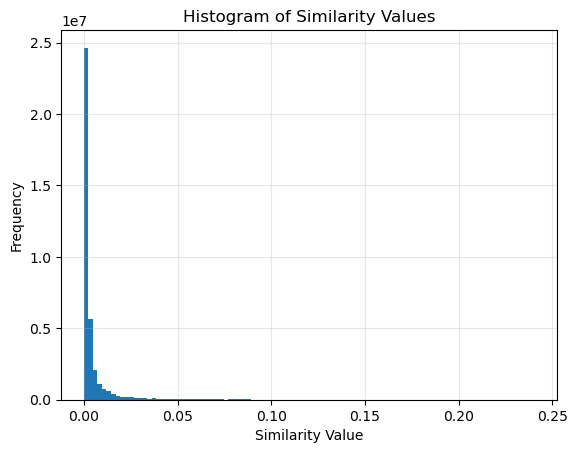

In [ ]:
sigma = 1.5  # Adjust sigma as needed for kernel smoothing
similarity_matrix = np.exp(-kernel_matrix / sigma**2)
# Set diagonal to zero to avoid self-similarity
similarity_matrix -= np.diag(np.diag(similarity_matrix))
print(similarity_matrix.min(), similarity_matrix.max())
plt.hist(similarity_matrix.flatten(), bins=100)
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Values')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# create diffusion matrix
markov_chain = similarity_matrix / similarity_matrix.sum(axis=0)

# compute eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(
    markov_chain.T)
eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)
eigv_inv = scipy.linalg.pinv(eigenvectors)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
eigv_inv = eigv_inv[sorted_indices, :]

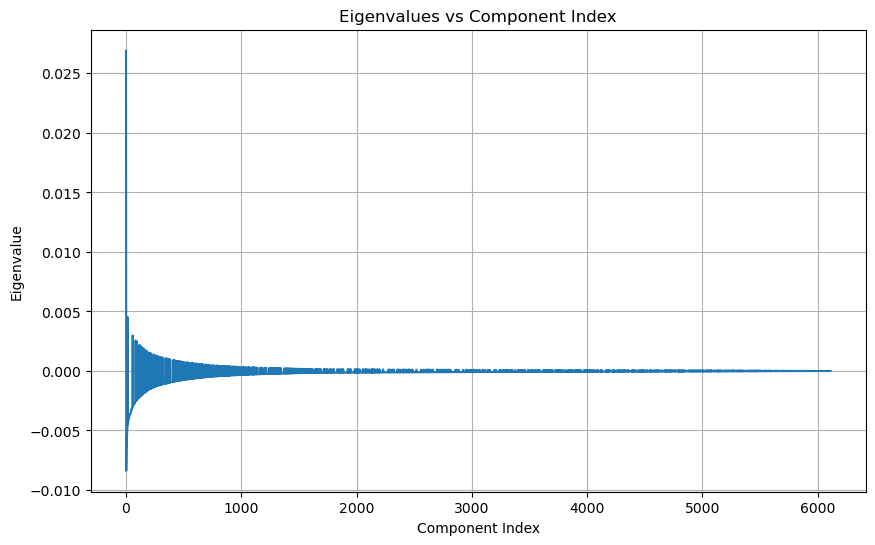

In [ ]:
# Plot eigenvalues to determine the number of components to use
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues[1:])
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues vs Component Index')
plt.grid(True)
plt.show()

In [ ]:
# Compute von Neumann entropy for multiple diffusion times t
t_values = np.linspace(1, 3, 17)
von_neumann_entropies = []

for t in tqdm(t_values):
    continue
    # Compute the diffused Markov matrix for time t
    eigv_power = np.diag(np.where(eigenvalues[:n_markov_components] > 0, eigenvalues[:n_markov_components]**t, eigenvalues[:n_markov_components]))
    M_t = eigv_inv[:n_markov_components].T @ eigv_power @ eigenvectors[:, :n_markov_components].T
    M_t = M_t @ M_t.T

    plt.imshow(M_t, cmap='viridis')
    plt.show()

    # Normalize eigenvalues to form a probability distribution
    eigenvalues_t = np.linalg.eigvalsh(M_t)
    eigenvalues_t = np.real(eigenvalues_t) + 1e-10  # Ensure eigenvalues are real
    eigenvalues_t = np.abs(eigenvalues_t) / np.sum(eigenvalues_t)

    # Compute von Neumann entropy
    entropy = -np.sum(eigenvalues_t * np.log(eigenvalues_t))
    if np.isnan(entropy) or np.isinf(entropy):
        print(f"Warning: Entropy calculation resulted in NaN or Inf for t={t}. Skipping this value.")
        continue
    von_neumann_entropies.append(entropy)
    if t == t_values[-1]:
        # Plot von Neumann entropy vs diffusion time
        plt.figure(figsize=(10, 6))
        plt.plot(t_values, von_neumann_entropies, marker='o')
        plt.semilogy()
        plt.xlabel('Diffusion Time (t)')
        plt.ylabel('Von Neumann Entropy')
        plt.title('Von Neumann Entropy vs Diffusion Time')
        plt.grid(True)
        plt.show()

100%|██████████| 17/17 [00:00<00:00, 536114.05it/s]


In [ ]:
# find points lying on the geodesic path, i.e. interpolating on the manifold
# - got to the nearest point that is still closer to the reference point than the current point?

# - build k nearest neighbors graph with small k, large enough to connect
# - find shortest path with A*

# Calculate pairwise diffusion distances using einsum


# Choose a diffusion time t 1, 1.5, 2, 2.5
# higher diffusion time will seperate high entropy points more from low entropy points,
# results in longer paths between points with low and high entropy
t = 1.3
# Compute the diffused Markov matrix for time t
#M_t = eigv_inv[:n_markov_components].T @ np.diag(eigenvalues[:n_markov_components])**t @ eigenvectors[:, :n_markov_components].T

if t % 1 != 0:
    # only raise positive eigenvalues to power t
    #eigv_power = np.diag(np.where(eigenvalues[:n_markov_components] > 0, eigenvalues[:n_markov_components]**t, eigenvalues[:n_markov_components]))
    # Use fractional matrix power for non-integer t
    #eigv_power = np.abs(fractional_matrix_power(np.diag(eigenvalues[:n_markov_components]), t))
    # use real part of fractional matrix power to avoid complex numbers
    #eigv_power = np.real(fractional_matrix_power(np.diag(eigenvalues[:n_markov_components]), t))
    eigv_power = np.diag(np.real(np.complex128(eigenvalues[:n_markov_components])**t))
else:
    eigv_power = np.diag(eigenvalues[:n_markov_components])**t
M_t = eigv_inv[:n_markov_components].T @ eigv_power @ eigenvectors[:, :n_markov_components].T
M_t = M_t.T
print(M_t.sum(axis=1), M_t.min(), M_t.max())

[1. 1. 1. ... 1. 1. 1.] -0.00037367847304825216 0.005194859125031992


In [ ]:
x, y, z = M_t[:, 1:4][:, 0], M_t[:, 1:4][:, 1], M_t[:, 1:4][:, 2]
plt.figure(figsize=(10, 8))
plt.scatter(x, y, alpha=0.6, s=30)
plt.xlabel('First Diffusion Component')
plt.ylabel('Second Diffusion Component')
plt.title(f'2D Scatter Plot of Diffusion Map Embedding (t={t})')
plt.grid(True, alpha=0.3)
plt.show()

Sample diffusion distance: 0.004051060734610927


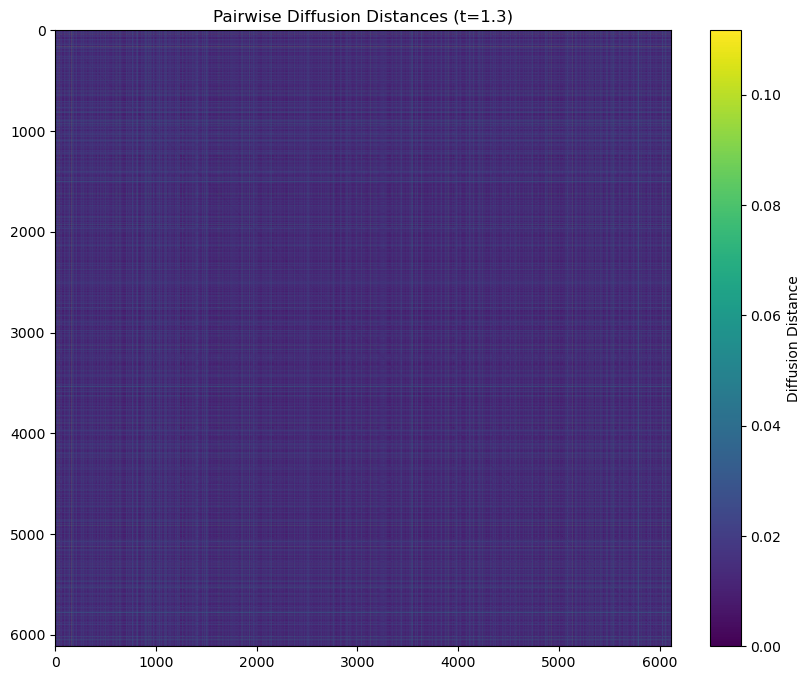

In [ ]:
@njit(parallel=True)
def compute_diffusion_distances(M_t, stationary_distribution):
    n = M_t.shape[0]
    diffusion_distances = np.zeros((n, n))
    for i in prange(n):
        for j in range(i + 1, n):
            diff = M_t[i] - M_t[j]
            distance = np.sum((diff**2) / stationary_distribution)
            diffusion_distances[i, j] = distance
            diffusion_distances[j, i] = distance  # Symmetric matrix
    return diffusion_distances

# Compute pairwise diffusion distances
diffusion_distances = compute_diffusion_distances(M_t, eigenvectors[:, 0]**2)
diffusion_distances = np.sqrt(diffusion_distances)  # Take square root to get distances

# Print a sample diffusion distance
print(f"Sample diffusion distance: {diffusion_distances[0, 1]}")

plt.figure(figsize=(10, 8))
plt.imshow(diffusion_distances, cmap='viridis')
plt.colorbar(label='Diffusion Distance')
plt.title(f'Pairwise Diffusion Distances (t={t})')
plt.show()

In [ ]:
# Create KNN graph
k = 5
n = diffusion_distances.shape[0]
knn_graph = np.zeros((n, n))

# For each point, find its k nearest neighbors
for i in range(n):
    # Get distances from point i to all other points
    distances = diffusion_distances[i]
    # Find indices of k nearest neighbors (excluding itself)
    nearest_indices = np.argsort(distances)[1:k+1]
    # Add edges to KNN graph
    knn_graph[i, nearest_indices] = distances[nearest_indices]
    knn_graph[nearest_indices, i] = distances[nearest_indices]  # Make the graph undirected

# Convert to sparse matrix for efficiency
sparse_knn_graph = csr_matrix(knn_graph)

# Create a NetworkX graph
G = nx.Graph(sparse_knn_graph)

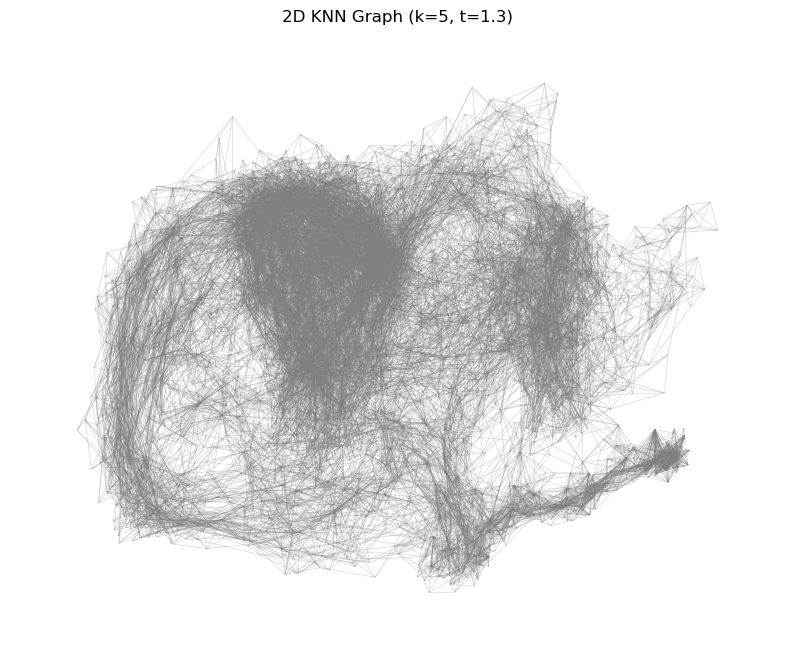

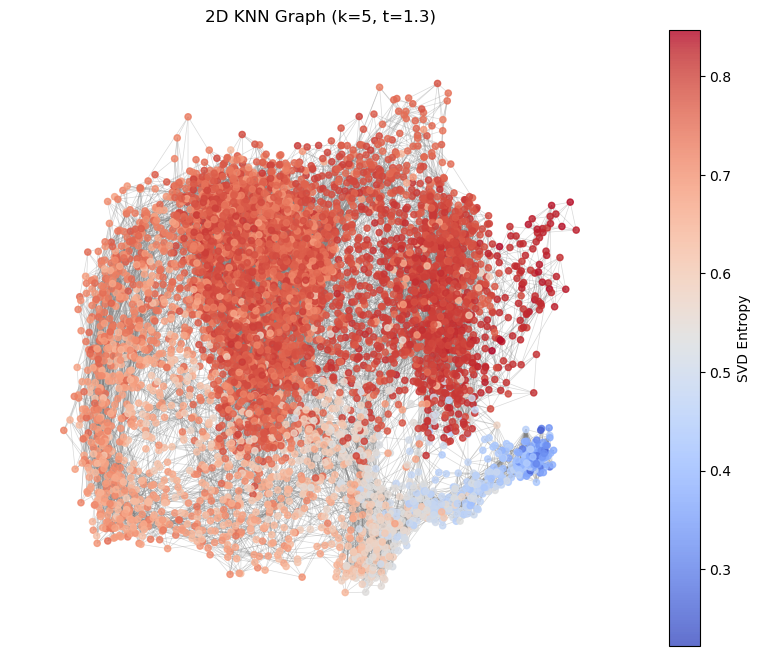

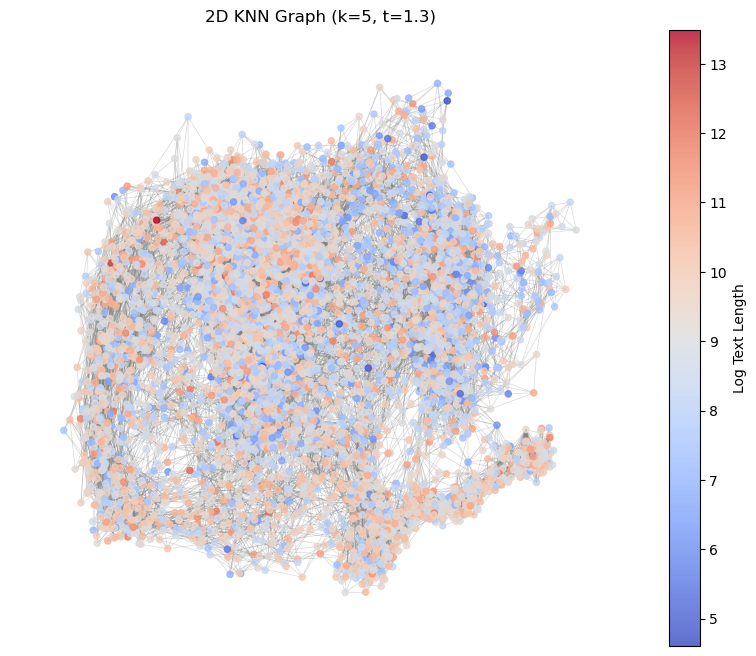

In [ ]:
# Create compact 2D spring layout visualization
pos_2d = nx.spring_layout(G, iterations=50, seed=42)

# Draw edges and nodes
plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos_2d, alpha=0.3, width=0.5, edge_color='gray')
plt.title(f'2D KNN Graph (k={k}, t={t})')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos_2d, alpha=0.3, width=0.5, edge_color='gray')
scatter = nx.draw_networkx_nodes(G, pos_2d, node_size=20, 
                                node_color=df_corpus["svd_entropy"], 
                                cmap='coolwarm', alpha=0.8)
plt.colorbar(scatter, label='SVD Entropy')
plt.title(f'2D KNN Graph (k={k}, t={t})')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos_2d, alpha=0.3, width=0.5, edge_color='gray')
scatter = nx.draw_networkx_nodes(G, pos_2d, node_size=20, 
                                node_color=np.log(df_corpus["text"].str.len()), 
                                cmap='coolwarm', alpha=0.8)
plt.colorbar(scatter, label='Log Text Length')
plt.title(f'2D KNN Graph (k={k}, t={t})')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos_2d, alpha=0.3, width=0.5, edge_color='gray')
scatter = nx.draw_networkx_nodes(G, pos_2d, node_size=20, 
                                node_color=df_corpus["topic"],
                                alpha=0.8)
plt.title(f'2D KNN Graph (k={k}, t={t})')
plt.axis('off')
plt.show()

In [ ]:
df_corpus[["text", "svd_entropy"]].sample(50).sort_values(by="svd_entropy")

text  svd_entropy
2150390  # MIT 18.06SC Linear Algebra Session 1.1 - 1.5...     0.341351
3173627  # SubsectionThe Assignment\n\n• Read section 2...     0.342131
3390440  ## WHY?\n\nPolicy gradient usually requires in...     0.356517
162029   # Universal approximation theorem\n\nIn the ma...     0.481193
2176635  # 3Blue1Brown’s Linear Algebra series¶\n\n## V...     0.510388
912046   # Quantum information\n\nIn physics and comput...     0.525441
2434639  # Policy Gradient Theorem and REINFORCE\n\nDow...     0.527273
3606300  # Quantum information\n\n(Redirected from Quan...     0.560985
2274443  # Special linear Lie algebra\n\nIn mathematics...     0.578509
1077543  # Stability (learning theory)\n\nStability, al...     0.580529
1962910  # Constructing skill trees\n\nConstructing ski...     0.622948
661229   # MNIST Digits With Keras\n\n## Imports\n\nThe...     0.631161
2513238  # Limit laws: weak law of large numbers\n\nPub...     0.640930
993568   Using random sampling to illustrate the Centra...     0.679099
2182785  # Rectifier (neural networks)\n\nPlot of the r...     0.681995
1901384  ### Linear regression\n\nWe transpose $w$ beca...     0.696837
2004147  # Reproducing kernel Hilbert spaces\n\n$\Decla...     0.712233
4578237  ## Introduction\n\nIn the United States, more ...     0.713164
3068565  # Structural risk minimization\n\nStructural r...     0.732516
4576294  # Brendan Hasz\n\nData Scientist at\nMinneapol...     0.734255
2586147  # 3. Baseline models & k-Nearest Neighbours¶\n...     0.735061
473783   ## Introduction\n\nThe theory of how humans ex...     0.742424
280751   # Ruin theory\n\n(Redirected from Cramer-Lundb...     0.743908
2573167  Deep Neural Network Library (DNNL)  1.2.0\nPer...     0.747171
6202456  ## Background\n\nUp until now we have seen the...     0.754518
2215743  Mandar Chandorkar PhD Researcher Applied mathe...     0.758497
425      The paradigm of learning by trial-and-error, e...     0.761685
2986518  In this lecture we will analize an online lear...     0.763223
501933   Content based on Erle Robotics's whitepaper: E...     0.764364
2425596  Introduction\n\nSupervised learning with deep ...     0.767199
1177662  Learning from Data to Predict¶\n\nKey themes¶\...     0.769520
1606528  Miles Martinez Graduate student in the cogniti...     0.771267
4390241  We argue that reliable evaluation in the few r...     0.776264
5354235  Published:\n\n# Introduction\n\nNeural network...     0.782804
5771216  # Pearls of Causality #5: Statistical vs Causa...     0.785568
1265396  # Random NumberGenerators\n\n#### The Art of M...     0.787053
3731126  # Policies.GLR_UCB module¶\n\nThe GLR-UCB poli...     0.791281
5401932  # [Notes on Mathematics for ESL] Chapter 4: Li...     0.793292
1279523  # Chapter 1 Introduction\n\nThe R convey libra...     0.793585
1021617  “Solving a problem simply means representing i...     0.795351
6034083  ## Introduction\n\nMany important molecular, l...     0.795362
5486199  # Bayesian Statistics using Julia and Turing\n...     0.798033
5022760  # Train Resnet50 on ImageNet with PyTorchedit\...     0.798544
1572512  # Intro\n\nI have two desires - learning Pytho...     0.801019
5109095  Thank you for visiting nature.com. You are usi...     0.803406
2543074  ## Packages\n\nimport tensorflow as tf\nimport...     0.805385
2478253  # Poisson scatter theorem\n\nIn probability th...     0.808275
4838408  Review Article | Open | Published:\n\n# Artifi...     0.810841
4271053  Started shallow, going deep.\n\n— Matt and Kim...     0.811991
1582340  # Symmetric Positive Definite Neural Networks ...     0.813361

Start point index: 1520, Text: # Introducing matrices

Published:

Here, I will introduce the three main ways of thinking about mat...
End point index: 216, Text: # LSTMs

2 minute read

$\$

# LSTMs to Model Physiological Time Series

Harini Suresh, Nicholas Loc...
Geodesic path from point 1520 to point 216:
[1520, 3570, 3938, 2503, 4520, 3189, 3078, 1371, 4137, 5528, 5793, 5949, 1665, 6028, 1399, 2447, 4507, 6042, 216]
Path length: 0.0822


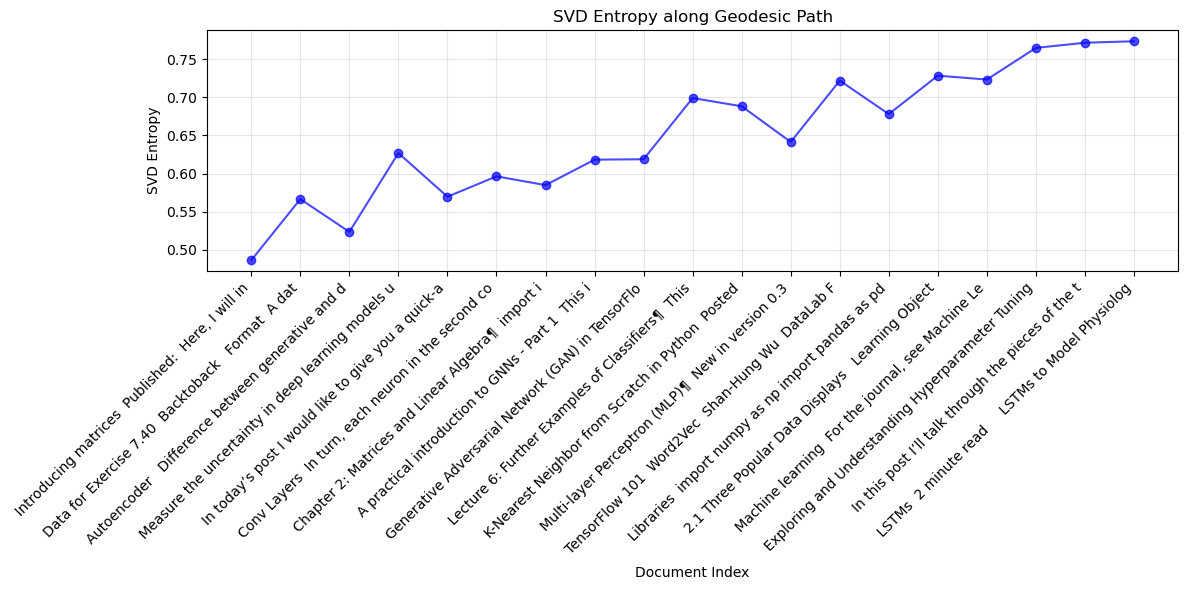

url  \
0                  mbernste.github.io/posts/matrices/   
1   alanarnholt.github.io/BSDA/reference/Backtobac...   
2   ekbanaml.github.io/generative20deep20learning/...   
3   fairyonice.github.io/Measure-the-uncertainty-i...   
4             jzuern.github.io/blog/2019/autoencoder/   
5    csy99.github.io/Blog/2020/07/22/hands-on-14-cnn/   
6   libigl.github.io/libigl-python-bindings/tut-ch...   
7   danielegrattarola.github.io/posts/2021-03-03/g...   
8                     mlnotebook.github.io/post/GAN4/   
9   nbviewer.jupyter.org/github/JunyoungLim/Junyou...   
10  kenzotakahashi.github.io/k-nearest-neighbor-fr...   
11   matousc89.github.io/padasip/sources/ann/mlp.html   
12  nthu-datalab.github.io/ml/labs/10_TensorFlow10...   
13  victoromondi1997.github.io/blog/statistical-th...   
14  saylordotorg.github.io/text_introductory-stati...   
15             en.wikipedia.org/wiki/Machine_learning   
16  mlr-org.github.io/Exploring-and-Understanding-...   
17     n-s-f.github.io/2017/07/10/rnn-tensorflow.html   
18                         oliviaseow.github.io/LSTM/   

                                                 text  svd_entropy  
0    Introducing matrices  Published:  Here, I wil...       0.4861  
1   Data for Exercise 7.40  Backtoback   Format  A...       0.5664  
2    Autoencoder   Difference between generative a...       0.5233  
3    Measure the uncertainty in deep learning mode...       0.6269  
4   In today’s post I would like to give you a qui...       0.5695  
5   Conv Layers  In turn, each neuron in the secon...       0.5963  
6    Chapter 2: Matrices and Linear Algebra¶  impo...       0.5848  
7    A practical introduction to GNNs - Part 1  Th...       0.6182  
8    Generative Adversarial Network (GAN) in Tenso...       0.6188  
9    Lecture 6: Further Examples of Classifiers¶  ...       0.6992  
10   K-Nearest Neighbor from Scratch in Python  Po...       0.6884  
11   Multi-layer Perceptron (MLP)¶  New in version...       0.6415  
12   TensorFlow 101  Word2Vec  Shan-Hung Wu  DataL...       0.7221  
13   Libraries  import numpy as np import pandas a...       0.6781  
14   2.1 Three Popular Data Displays   Learning Ob...       0.7286  
15   Machine learning  For the journal, see Machin...       0.7235  
16   Exploring and Understanding Hyperparameter Tu...       0.7651  
17  In this post I’ll talk through the pieces of t...       0.7719  
18   LSTMs  2 minute read     LSTMs to Model Physi...       0.7738

In [ ]:
# Define start and end points (you can change these)
# Find the index of the document containing "Attention Is All You Need"
df_corpus = df_corpus.reset_index(drop=True)
search_term = "Introducing matrices"
#search_term = "Multicollinearity"
df_corpus["match_position"] = df_corpus["text"].str.find(search_term)

# Select the document where the match is closest to the beginning of the text
start_point = df_corpus.loc[df_corpus["match_position"] >= 0, "match_position"].idxmin()
print(f"Start point index: {start_point}, Text: {df_corpus.loc[start_point, 'text'][:100]}...")

search_term = "LSTM"
df_corpus["match_position"] = df_corpus["text"].str.find(search_term)

# Select the document where the match is closest to the beginning of the text
end_point = df_corpus.loc[df_corpus["match_position"] >= 0, "match_position"].idxmin()
print(f"End point index: {end_point}, Text: {df_corpus.loc[end_point, 'text'][:100]}...")

# Find shortest path using Dijkstra's algorithm
try:
    path = nx.dijkstra_path(G, start_point, end_point, weight='weight')
    path_length = nx.dijkstra_path_length(G, start_point, end_point, weight='weight')
    print(f"Geodesic path from point {start_point} to point {end_point}:")
    print(path)
    print(f"Path length: {path_length:.4f}")
except nx.NetworkXNoPath:
    print(f"No path found between {start_point} and {end_point}. Try increasing k.")

df_temp = df_corpus.loc[df_corpus.index[path], ["url", "text", "svd_entropy"]].reset_index(drop=True)
df_temp["text"] = df_temp["text"].str[:125].str.replace("#", "").str.replace("%", "").str.replace("&", "").str.replace("$", "").str.replace("_", "").str.replace("{", "").str.replace("}", "").str.replace("\\", "").str.replace("^", "").str.replace("~", "").str.replace("\n", " ") + " ..."
df_temp["url"] = df_temp["url"].str.replace("https://", "").str.replace("http://", "").str.replace("%", "")
df_temp["svd_entropy"] = df_temp["svd_entropy"].round(4)
plt.figure(figsize=(12, 6))
df_temp["svd_entropy"].plot(marker='o', linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Document Index')
plt.ylabel('SVD Entropy')
plt.title('SVD Entropy along Geodesic Path')
plt.xticks(df_temp.index, df_temp["text"].str[:50].replace('\n', ' '), rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
df_temp

In [ ]:
df_temp[["text", "svd_entropy"]].reset_index().to_latex("geodesic_path.tex", index=False, escape=False,
                 column_format='|c|p{12cm}|c|',
                 header=["Index", "Text (first 125 chars)", "SVD Entropy"],
                 caption="Geodesic Path from Start to End Point",
                 label="tab:geodesic_path",
                 position="htbp")

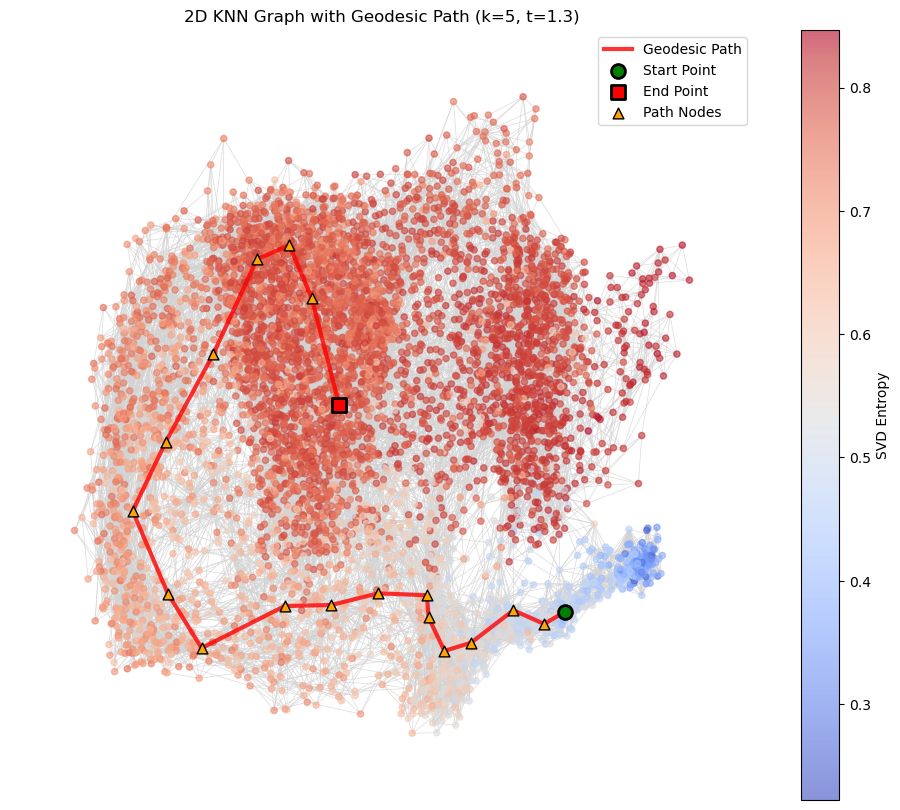

In [ ]:
# Plot the spring layout with the geodesic path highlighted
plt.figure(figsize=(12, 10))

# Draw all edges in light gray
nx.draw_networkx_edges(G, pos_2d, alpha=0.8, width=0.5, edge_color='lightgray')

# Draw all nodes colored by SVD entropy
scatter = nx.draw_networkx_nodes(G, pos_2d, node_size=20, 
                                node_color=df_corpus["svd_entropy"], 
                                cmap='coolwarm', alpha=0.6)

# Highlight the path nodes in larger size
if 'path' in locals():
    path_nodes = [pos_2d[node] for node in path]
    path_x = [pos[0] for pos in path_nodes]
    path_y = [pos[1] for pos in path_nodes]
    
    # Draw path as connected line
    plt.plot(path_x, path_y, 'r-', linewidth=3, alpha=0.8, label='Geodesic Path')
    
    # Highlight start and end points
    plt.scatter([path_x[0]], [path_y[0]], s=100, c='green', marker='o', 
               label='Start Point', edgecolors='black', linewidth=2, zorder=5)
    plt.scatter([path_x[-1]], [path_y[-1]], s=100, c='red', marker='s', 
               label='End Point', edgecolors='black', linewidth=2, zorder=5)
    
    # Highlight intermediate path nodes
    if len(path_x) > 2:
        plt.scatter(path_x[1:-1], path_y[1:-1], s=60, c='orange', marker='^', 
                   label='Path Nodes', edgecolors='black', linewidth=1, zorder=4)

plt.colorbar(scatter, label='SVD Entropy')
plt.title(f'2D KNN Graph with Geodesic Path (k={k}, t={t})')
plt.legend()
plt.axis('off')
plt.show()